# **Speech Emotion Recognition using TESS + RAVDESS dataset**

## Import libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import librosa 
import IPython.display as display
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, Dropout
import joblib

## Dataset
- In this project, I am combining **Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)** and **Toronto Emotion Speech Set (TESS)** dataset.
- Know more about <a href="https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data">RAVDESS</a>
- Know more about <a href="https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess/data">TESS</a>

#### `File name convention`
- RAVDESS 
    - Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav).
    - Seven male actors, seven female actresses.
    - Eight emotions => (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    - Filename example: 03-01-06-01-02-01-12.wav
        - Audio-only (03)
        - Speech (01)
        - Fearful (06)
        - Normal intensity (01)
        - Statement "dogs" (02)
        - 1st Repetition (01)
        - 12th Actor (12)
- TESS
    - There are 2800 data points (audio files) in total. 200 spoken words.
    - All female voices.
    -  Seven emotions => anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral.
    - Filename example: OAF_back_angry
        - Author name (OAF)
        - Spoken word (back)
        - Emotion (angry)

#### Observing random audio files

In [2]:
emotion_dict_ravdess = {
    0 : 'neutral', 
    1 : 'calm', 
    2 : 'happy',
    3 : 'sad', 
    4 : 'angry', 
    5 : 'fearful', 
    6 : 'disgust', 
    7 : 'surprised'
}
emotion_dict_ravdess

{0: 'neutral',
 1: 'calm',
 2: 'happy',
 3: 'sad',
 4: 'angry',
 5: 'fearful',
 6: 'disgust',
 7: 'surprised'}

In [3]:
TESS_PATH = r"D:\Programming\Machine Learning\Datasets\Sound classification\speech_emotion_tess_ravdess\TESS"
RAVDESS_PATH = r"D:\Programming\Machine Learning\Datasets\Sound classification\speech_emotion_tess_ravdess\RAVDESS"

In [4]:
def show_random_audio_file(dataset):
    plt.figure(figsize = (12, 2))

    if(dataset.lower() == 'tess'):
        # Choosing random file from TESS dataset
        random_dir = random.choice(os.listdir(TESS_PATH))  # random directory
        random_dir_files = os.listdir(os.path.join(TESS_PATH, random_dir)) # list all files within it
        random_audio_file = random.choice(random_dir_files) # Choose a random file
        author, word, emotion = random_audio_file.split("_") # Get the infos from the filename
        emotion = emotion.split(".")[0]
        audio_data, sampling_rate = librosa.load(os.path.join(TESS_PATH, random_dir, random_audio_file))  # Loading the random audio file
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(audio_data)  # Plotting the audio signal
        plt.title(f"Author: {author} | Word: {word} | Emotion: {emotion}")

        # Melspectrogram
        plt.subplot(1, 2, 2)
        mel_spectorgram = librosa.feature.melspectrogram(y = audio_data)
        amp_to_db = librosa.amplitude_to_db(np.abs(mel_spectorgram), ref = np.max)
        librosa.display.specshow(amp_to_db, x_axis='time', y_axis='hz', sr = sampling_rate)
        plt.colorbar()
        plt.title("Melspectrogram")

        return display.Audio(os.path.join(TESS_PATH, random_dir, random_audio_file))  
    else:
        random_author = random.choice(os.listdir(RAVDESS_PATH))
        random_files = os.listdir(os.path.join(RAVDESS_PATH, random_author))
        random_audio_file = random.choice(random_files)
        _, _, emotion,_ ,_, _, _ = random_audio_file.split("-")
        emotion = emotion_dict_ravdess[int(emotion) - 1]   # Original 1 to 8, dict contains 0 to 7
        audio_data, sampling_rate = librosa.load(os.path.join(RAVDESS_PATH, random_author, random_audio_file))

        plt.subplot(1, 2, 1)
        librosa.display.waveshow(audio_data)
        plt.title(f"Emotion: {emotion}")

        plt.subplot(1, 2, 2)
        mel_spectorgram = librosa.feature.melspectrogram(y = audio_data)
        amp_to_db = librosa.amplitude_to_db(np.abs(mel_spectorgram), ref = np.max)
        librosa.display.specshow(amp_to_db, x_axis='time', y_axis='hz', sr = sampling_rate)
        plt.colorbar()
        plt.title("Melspectrogram")

        return display.Audio(os.path.join(RAVDESS_PATH, random_author, random_audio_file))
        

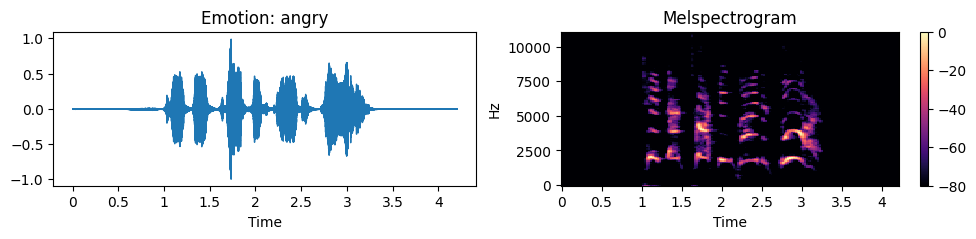

In [5]:
show_random_audio_file('ravdess')

### Load dataset

In [6]:
ravdess_label_dict = {     # 'Calm' emotion is not present in TESS, no need to add it
    '01': 0,   # Neutral
    '03': 1,   # Happy
    '04': 2,   # Sad
    '05': 3,   # Angry
    '06': 4,   # Fear
    '07': 5,   # Disgust
    '08': 6,   # Surprised
}

tess_label_dict = {
    'neutral': 0,
    'happy': 1,   
    'sad': 2,
    'angry': 3,
    'fear': 4,
    'disgust': 5,
    'ps': 6,    # surprised
}

In [7]:
def load_data(n_mfcc = 64):
    
    audio_mfcc = []
    label = []

    # RAVDESS
    for dir in tqdm_notebook(os.listdir(RAVDESS_PATH), desc = 'Loading RAVDESS data'):
        dir_path = os.path.join(RAVDESS_PATH, dir)
        for audio in os.listdir(dir_path):
            _, _, emotion,_ ,_, _, _ = audio.split("-")
            if(emotion != '02'):   # skipping for 'calm' emotion
                label.append(ravdess_label_dict[emotion]) 
                audio_data, sampling_rate = librosa.load(os.path.join(RAVDESS_PATH, dir, audio))
                mfcc = librosa.feature.mfcc(y = audio_data, sr = sampling_rate, n_mfcc = n_mfcc)
                mfcc_mean = np.mean(mfcc.T, axis = 0)
                audio_mfcc.append(mfcc_mean)

    # TESS
    for dir in tqdm_notebook(os.listdir(TESS_PATH), desc = 'Loading TESS data'):
        dir_path = os.path.join(TESS_PATH, dir)
        for audio in os.listdir(dir_path):
            _, _, emotion = audio.split("_")  # Get the infos from the filename
            emotion = emotion.split(".")[0]
            label.append(tess_label_dict[emotion])
            audio_data, sampling_rate = librosa.load(os.path.join(TESS_PATH, dir, audio))
            mfcc = librosa.feature.mfcc(y = audio_data, sr = sampling_rate, n_mfcc = n_mfcc)
            mfcc_mean = np.mean(mfcc.T, axis = 0)
            audio_mfcc.append(mfcc_mean)

    return audio_mfcc, label

In [8]:
X, y = load_data(n_mfcc = 64)

Loading RAVDESS data:   0%|          | 0/24 [00:00<?, ?it/s]

Loading TESS data:   0%|          | 0/14 [00:00<?, ?it/s]

In [9]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((4048, 64), (4048,))

### Label distribution

In [10]:
label_dict = {
    0: 'neutral',
    1: 'happy',
    2: 'sad',
    3: 'angry',
    4: 'fear',
    5: 'disgust',
    6: 'surprised'}
label_dict

{0: 'neutral',
 1: 'happy',
 2: 'sad',
 3: 'angry',
 4: 'fear',
 5: 'disgust',
 6: 'surprised'}

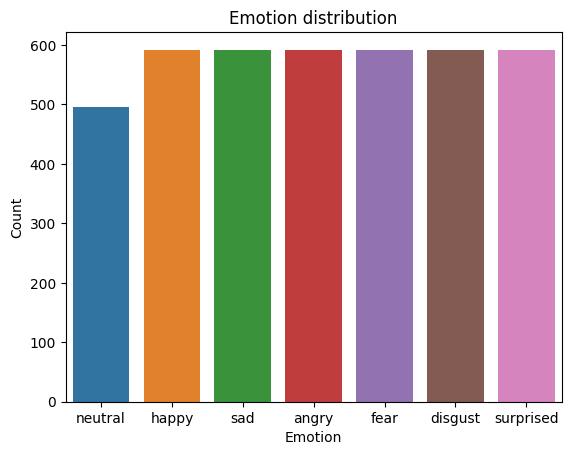

In [11]:
label_counts = pd.Series(y).value_counts()
sns.barplot(x = label_counts.index, y = label_counts.values)
plt.xticks(ticks = np.arange(7), labels=label_dict.values())
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Emotion distribution");

## Modelling experiments

### Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3036, 64), (1012, 64), (3036,), (1012,))

In [13]:
def model_performance(y_test, y_pred):
    return{
        'accuracy': np.round(accuracy_score(y_test, y_pred), 3),
        'recall': np.round(recall_score(y_test, y_pred, average = 'macro'), 3),
        'precision': np.round(precision_score(y_test, y_pred, average = 'macro'), 3),
        'f1_score': np.round(f1_score(y_test, y_pred, average = 'macro'), 3)
    }

### Random forest classifier

In [30]:
rdf = RandomForestClassifier(n_jobs = -1, random_state = 48)
rdf.fit(X_train, y_train)
y_pred_rdf = rdf.predict(X_test)

rdf_performance = model_performance(y_test, y_pred_rdf)
rdf_performance

{'accuracy': 0.857, 'recall': 0.857, 'precision': 0.867, 'f1_score': 0.86}

### Gradient Boosting

In [29]:
gbc = GradientBoostingClassifier(random_state = 48)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

gbc_performance = model_performance(y_test, y_pred_gbc)
gbc_performance

{'accuracy': 0.825, 'recall': 0.828, 'precision': 0.827, 'f1_score': 0.826}

### LightBoost

In [31]:
lgbm = LGBMClassifier(n_jobs = -1, random_state = 48)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

lgbm_performance = model_performance(y_test, y_pred_lgbm)
lgbm_performance

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 3036, number of used features: 64
[LightGBM] [Info] Start training from score -2.065053
[LightGBM] [Info] Start training from score -1.895803
[LightGBM] [Info] Start training from score -1.956839
[LightGBM] [Info] Start training from score -1.911273
[LightGBM] [Info] Start training from score -1.929251
[LightGBM] [Info] Start training from score -1.949871
[LightGBM] [Info] Start training from score -1.922472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

{'accuracy': 0.878, 'recall': 0.881, 'precision': 0.882, 'f1_score': 0.88}

### XGBoost

In [19]:
xgb = XGBClassifier(n_jobs = -1, random_state = 48)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

xgb_performance = model_performance(y_test, y_pred_xgb)
xgb_performance

{'accuracy': 0.875, 'recall': 0.877, 'precision': 0.875, 'f1_score': 0.875}

### CatBoost

In [14]:
ctb = CatBoostClassifier(random_state = 48)
ctb.fit(X_train, y_train)
y_pred_ctb = ctb.predict(X_test)

ctb_performance = model_performance(y_test, y_pred_ctb)
ctb_performance

Learning rate set to 0.083738
0:	learn: 1.8092136	total: 194ms	remaining: 3m 13s
1:	learn: 1.7164906	total: 238ms	remaining: 1m 58s
2:	learn: 1.6349636	total: 273ms	remaining: 1m 30s
3:	learn: 1.5580275	total: 309ms	remaining: 1m 16s
4:	learn: 1.4958923	total: 345ms	remaining: 1m 8s
5:	learn: 1.4382142	total: 381ms	remaining: 1m 3s
6:	learn: 1.3878680	total: 421ms	remaining: 59.8s
7:	learn: 1.3464373	total: 457ms	remaining: 56.6s
8:	learn: 1.2930353	total: 495ms	remaining: 54.5s
9:	learn: 1.2519614	total: 532ms	remaining: 52.7s
10:	learn: 1.2169452	total: 569ms	remaining: 51.1s
11:	learn: 1.1867687	total: 603ms	remaining: 49.6s
12:	learn: 1.1599004	total: 639ms	remaining: 48.5s
13:	learn: 1.1282342	total: 677ms	remaining: 47.7s
14:	learn: 1.0939441	total: 716ms	remaining: 47s
15:	learn: 1.0611772	total: 781ms	remaining: 48s
16:	learn: 1.0361126	total: 826ms	remaining: 47.8s
17:	learn: 1.0143894	total: 866ms	remaining: 47.2s
18:	learn: 0.9967431	total: 904ms	remaining: 46.7s
19:	learn: 

{'accuracy': 0.886, 'recall': 0.888, 'precision': 0.889, 'f1_score': 0.887}

In [16]:
joblib.dump(ctb, 'catboost_model.pkl')

['catboost_model.pkl']

### Dense Model

- Configuring callbacks to save the best model

In [19]:
def model_ckpt(model_name):
    return ModelCheckpoint(
        filepath = f'{model_name}.keras',
        monitor = 'val_accuracy',
        save_best_only = True,
        verbose = 1
    )

- Function to plot the model performance through the epochs

In [ ]:
def plot_model_performance(hist):
    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    sns.lineplot(x = hist.epoch, y = hist.history['loss'], label = 'train_loss')
    sns.lineplot(x = hist.epoch, y = hist.history['val_loss'], label = 'test_loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    sns.lineplot(x = hist.epoch, y = hist.history['accuracy'], label = 'train_accuracy')
    sns.lineplot(x = hist.epoch, y = hist.history['val_accuracy'], label = 'test_accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.suptitle("Model performance")

In [108]:
model = Sequential()
model.add(Input(shape = (64,)))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.3))
model.add(Dense(units = 7, activation = 'softmax'))

In [109]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002),
    metrics = ['accuracy']
)

In [110]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 128)               8320      
                                                                 
 dense_81 (Dense)            (None, 256)               33024     
                                                                 
 dense_82 (Dense)            (None, 256)               65792     
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_83 (Dense)            (None, 256)               65792     
                                                                 
 dense_84 (Dense)            (None, 128)               32896     
                                                                 
 dropout_23 (Dropout)        (None, 128)             

In [111]:
model_history = model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), epochs = 500, batch_size = 64, callbacks = [model_ckpt('dense_2')], use_multiprocessing = True)

Epoch 1/500


45/48 [===========================>..] - ETA: 0s - loss: 3.3656 - accuracy: 0.2281
Epoch 1: val_accuracy improved from -inf to 0.42885, saving model to dense_2.keras
48/48 [==============================] - 2s 12ms/step - loss: 3.2780 - accuracy: 0.2335 - val_loss: 1.4758 - val_accuracy: 0.4289
Epoch 2/500
47/48 [============================>.] - ETA: 0s - loss: 1.3999 - accuracy: 0.4368
Epoch 2: val_accuracy improved from 0.42885 to 0.63538, saving model to dense_2.keras
48/48 [==============================] - 0s 7ms/step - loss: 1.3982 - accuracy: 0.4381 - val_loss: 1.0664 - val_accuracy: 0.6354
Epoch 3/500
47/48 [============================>.] - ETA: 0s - loss: 1.0894 - accuracy: 0.5778
Epoch 3: val_accuracy improved from 0.63538 to 0.69565, saving model to dense_2.keras
48/48 [==============================] - 0s 7ms/step - loss: 1.0889 - accuracy: 0.5787 - val_loss: 0.8437 - val_accuracy: 0.6957
Epoch 4/500
37/48 [======================>.......] - ETA: 0s - loss: 0.9132 - accura

In [33]:
best_dense_model = tf.keras.models.load_model('dense_2.keras')
best_dense_model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.9389 - accuracy: 0.8943


[0.9388949871063232, 0.8942687511444092]

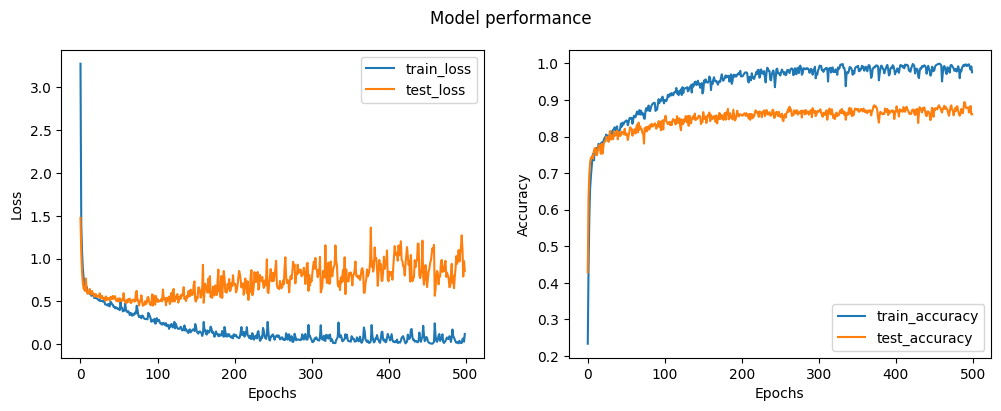

In [125]:
plot_model_performance(model_history)

In [34]:
dense_pred = best_dense_model.predict(X_test)
dense_pred = np.argmax(dense_pred, axis = 1)
model_performance(y_test, dense_pred)

32/32 [==============================] - 0s 1ms/step


{'accuracy': 0.894, 'recall': 0.896, 'precision': 0.895, 'f1_score': 0.895}

### LSTM + GRU model

- LSTM takes 2D input, that's why formatting the data

In [15]:
X_train_new = np.expand_dims(X_train, axis = -1)
X_test_new = np.expand_dims(X_test, axis = -1)
X_train_new.shape, X_test_new.shape

((3036, 64, 1), (1012, 64, 1))

In [38]:
model_2 = Sequential()
model_2.add(Input(shape = (64, 1)))
model_2.add(LSTM(units = 128, return_sequences = True))
model_2.add(GRU(units = 128, return_sequences = False))
model_2.add(Dense(units = 128, activation = 'relu'))
model_2.add(Dropout(rate = 0.5))
model_2.add(Dense(units = 128, activation = 'relu'))
model_2.add(Dense(units = 7, activation = 'softmax'))

In [39]:
model_2.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002),
    metrics = ['accuracy']
)

In [40]:
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64, 128)           66560     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 7)                 903       
                                                                 
Total params: 199559 (779.53 KB)
Trainable params: 199

In [41]:
lstm_hist = model_2.fit(x = X_train_new, y = y_train, validation_data = (X_test_new, y_test), epochs = 100, callbacks = [model_ckpt("lstm_model")], use_multiprocessing = True)

Epoch 1/100
95/95 [==============================] - ETA: 0s - loss: 1.5019 - accuracy: 0.3949
Epoch 1: val_accuracy improved from -inf to 0.59091, saving model to lstm_model.keras
95/95 [==============================] - 13s 84ms/step - loss: 1.5019 - accuracy: 0.3949 - val_loss: 1.1420 - val_accuracy: 0.5909
Epoch 2/100
95/95 [==============================] - ETA: 0s - loss: 1.1700 - accuracy: 0.5655
Epoch 2: val_accuracy improved from 0.59091 to 0.62549, saving model to lstm_model.keras
95/95 [==============================] - 7s 73ms/step - loss: 1.1700 - accuracy: 0.5655 - val_loss: 1.0111 - val_accuracy: 0.6255
Epoch 3/100
95/95 [==============================] - ETA: 0s - loss: 1.0024 - accuracy: 0.6334
Epoch 3: val_accuracy improved from 0.62549 to 0.63636, saving model to lstm_model.keras
95/95 [==============================] - 7s 77ms/step - loss: 1.0024 - accuracy: 0.6334 - val_loss: 1.0074 - val_accuracy: 0.6364
Epoch 4/100
95/95 [==============================] - ETA: 0s

In [42]:
best_lstm_gru_model = tf.keras.models.load_model("lstm_model.keras")
best_lstm_gru_model.evaluate(X_test_new, y_test)

32/32 [==============================] - 3s 31ms/step - loss: 0.7345 - accuracy: 0.8310


[0.7344937920570374, 0.8310276865959167]

In [48]:
lstm_pred = model_2.predict(X_test_new)
lstm_pred = np.argmax(lstm_pred, axis = 1)
model_performance(y_test, lstm_pred)

32/32 [==============================] - 1s 38ms/step


{'accuracy': 0.81, 'recall': 0.81, 'precision': 0.82, 'f1_score': 0.813}

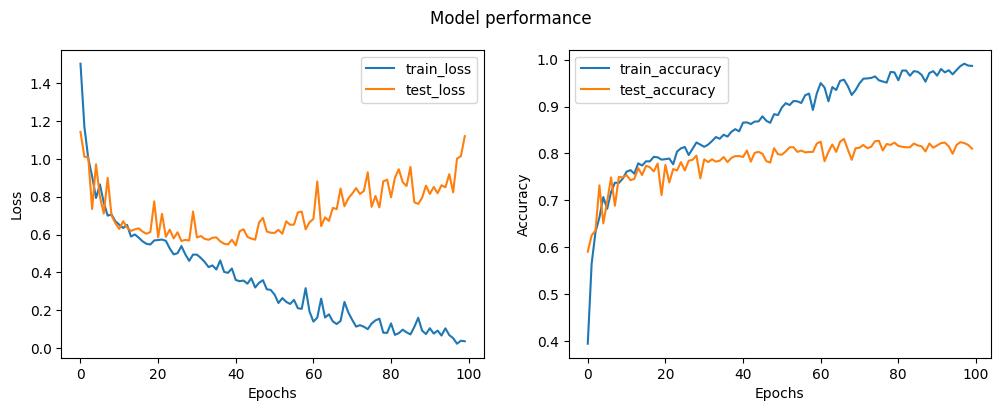

In [44]:
plot_model_performance(lstm_hist)

## Conclusuion

### **`Dense model` outperforms all the other models with f1_score of `~89.5%`**

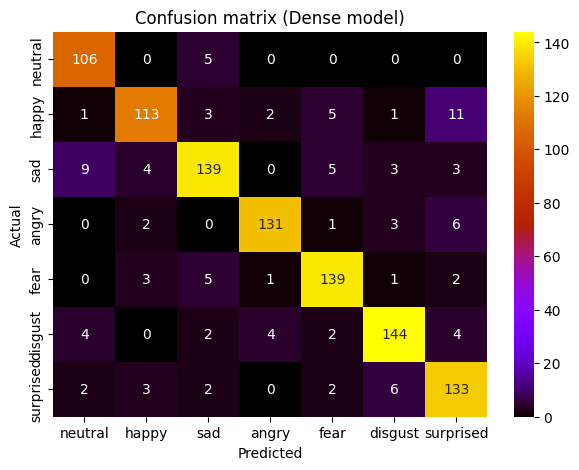

In [50]:
conf_matrix = confusion_matrix(y_test, dense_pred)

plt.figure(figsize = (7, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'gnuplot')
plt.title("Confusion matrix (Dense model)");
plt.xticks(np.arange(7) + .5, label_dict.values())
plt.yticks(np.arange(7) + .5, label_dict.values())
plt.xlabel("Predicted")
plt.ylabel("Actual");

In [54]:
print("Classification report for Dense model: ")
print(classification_report(y_test, dense_pred))  

Classification report for Dense model: 
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       111
           1       0.90      0.83      0.87       136
           2       0.89      0.85      0.87       163
           3       0.95      0.92      0.93       143
           4       0.90      0.92      0.91       151
           5       0.91      0.90      0.91       160
           6       0.84      0.90      0.87       148

    accuracy                           0.89      1012
   macro avg       0.89      0.90      0.89      1012
weighted avg       0.90      0.89      0.89      1012



## Future Scope
- Try tweaking the model parameters and `n_mfcc` parameter
- Use TESS or RAVDESS dataset alone without combing them
- Apply audio augmentation techniques
- Try with melspectrogram images and CNN

### *&copy; `Mainak Mukherjee` 29/03/2024*